In [49]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [50]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
# dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'

dirAgData = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'
dirEra5 = '/dartfs-hpc/rc/lab/C/CMIG/ERA5'

In [52]:
yearRange = [1981, 2019]

In [53]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [54]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)
    
with open('%s/kdd-era5-trends-Maize-1981-2019.dat'%dirAgData, 'rb') as f:
    kdd_trends = pickle.load(f)
with open('%s/gdd-era5-trends-Maize-1981-2019.dat'%dirAgData, 'rb') as f:
    gdd_trends = pickle.load(f)
with open('%s/pr-era5-trends-Maize-1981-2019.dat'%dirAgData, 'rb') as f:
    pr_trends = pickle.load(f)

In [55]:
with open('growing_season_len_maize.dat', 'rb') as f:
    growing_season_len = pickle.load(f)

heatwave_days = np.full([growing_season_len.shape[0], growing_season_len.shape[1], len(range(1980, 2018+1)), 6], np.nan)
coldwave_days = np.full([growing_season_len.shape[0], growing_season_len.shape[1], len(range(1980, 2018+1)), 6], np.nan)
for y, year in enumerate(range(1980, 2018+1)):
    with open('heat_wave_days/era5_heat_wave_days_%d.dat'%year, 'rb') as f:
        cur_heatwave_days = pickle.load(f)
        heatwave_days[:, :, y, :] = cur_heatwave_days[:, :, :]
    with open('heat_wave_days/era5_cold_wave_days_%d.dat'%year, 'rb') as f:
        cur_coldwave_days = pickle.load(f)
        coldwave_days[:, :, y, :] = cur_coldwave_days[:, :, :]

In [56]:
heatwave_days_xr = xr.DataArray(data=heatwave_days,
                                dims=['lat', 'lon', 'time', 'q'], 
                                coords={'lat':era5_lat, 'lon':era5_lon, 'time':range(yearRange[0], yearRange[1]+1), 'q':[0,1,2,3,4,5]})
heatwave_days_xr = xr.Dataset({'HW':heatwave_days_xr})

In [57]:
dask_hw   = heatwave_days_xr.chunk({'lat':10, 'lon':10, 'time':-1, 'q':-1})

In [58]:
dask_hw

,Array,Chunk
Bytes,1.94 GB,187.20 kB
Shape,"(721, 1440, 39, 6)","(10, 10, 39, 6)"
Count,10513 Tasks,10512 Chunks
Type,float64,numpy.ndarray


In [73]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

hw_trends = xr.apply_ufunc(linear_trend,
                        dask_hw.time, dask_hw.HW,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'], ['time']],# reduce along 'plev'
                        output_dtypes=['d'],
                        )

In [61]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

In [65]:
maize_ha_lat = np.linspace(90, -90, 2160)
maize_ha_lon = np.linspace(0, 360, 4320)

maize_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Maize/Maize_2005_Area.tif'%dirAgData)
maize_ha = maize_ha.read(1)
maize_ha[abs(maize_ha) > 10] = np.nan
maize_ha = np.roll(maize_ha, -int(maize_ha.shape[1]/2), axis=1)

In [66]:
regridMesh = xr.Dataset({'lat': (['lat'], np.linspace(90, -90, era5_lat.size)),
                         'lon': (['lon'], np.linspace(0, 360, era5_lon.size)),})

regridder = xe.Regridder(xr.DataArray(data=maize_ha, dims=['lat', 'lon'], coords={'lat':maize_ha_lat, 'lon':maize_ha_lon}), regridMesh, 'bilinear')
maize_ha_regrid = regridder(maize_ha)

In [ ]:
kdd_trends_zonal_anom = kdd_trends - np.matlib.repmat(np.nanmean(kdd_trends, axis=1), 1, 1).T
gdd_trends_zonal_anom = gdd_trends - np.matlib.repmat(np.nanmean(gdd_trends, axis=1), 1, 1).T

hw_trends_zonal_anom = hw_trends[:,:,4] - np.matlib.repmat(np.nanmean(hw_trends[:,:,4], axis=1), 1, 1).T

In [ ]:
maize_ha_regrid_1d = np.reshape(maize_ha_regrid, [maize_ha_regrid.size, 1])
kdd_trends_1d = np.reshape(kdd_trends, [kdd_trends.size, 1])
kdd_trends_zonal_anom_1d = np.reshape(kdd_trends_zonal_anom, [kdd_trends_zonal_anom.size, 1])

gdd_trends_1d = np.reshape(gdd_trends, [gdd_trends.size, 1])
gdd_trends_zonal_anom_1d = np.reshape(gdd_trends_zonal_anom, [gdd_trends_zonal_anom.size, 1])

hw_trends_1d = np.reshape(hw_trends, [hw_trends.size, 1])
hw_trends_zonal_anom_1d = np.reshape(hw_trends_zonal_anom, [hw_trends_zonal_anom.size, 1])

In [69]:
nn = np.where((~np.isnan(kdd_trends_zonal_anom_1d)) & (~np.isnan(maize_ha_regrid_1d)))[0]
X = sm.add_constant(maize_ha_regrid_1d[nn])
mdl_kdd = sm.OLS(kdd_trends_zonal_anom_1d[nn], X).fit()

nn = np.where((~np.isnan(gdd_trends_zonal_anom_1d)) & (~np.isnan(maize_ha_regrid_1d)))[0]
X = sm.add_constant(maize_ha_regrid_1d[nn])
mdl_gdd = sm.OLS(gdd_trends_zonal_anom_1d[nn], X).fit()

nn = np.where((~np.isnan(hw_trends_zonal_anom_1d)) & (~np.isnan(maize_ha_regrid_1d)))[0]
X = sm.add_constant(maize_ha_regrid_1d[nn])
mdl_hw = sm.OLS(hw_trends_zonal_anom_1d[nn], X).fit()

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(maize_ha_regrid_1d, hw_trends_zonal_anom_1d)
plt.plot([0, .6], [mdl_hw.params[0], mdl_hw.params[0]+.6*mdl_hw.params[1]], '--k', lw=2)
plt.xlabel('Fractional crop cover')
plt.ylabel('HW trend zonal anomaly')

Text(0, 0.5, 'KDD trend zonal anomaly')

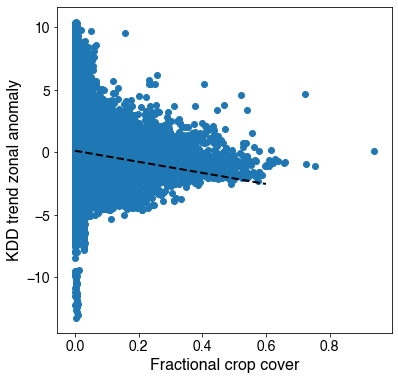

In [70]:
plt.figure(figsize=(6,6))
plt.scatter(maize_ha_regrid_1d, kdd_trends_zonal_anom_1d)
plt.plot([0, .6], [mdl_kdd.params[0], mdl_kdd.params[0]+.6*mdl_kdd.params[1]], '--k', lw=2)
plt.xlabel('Fractional crop cover')
plt.ylabel('KDD trend zonal anomaly')

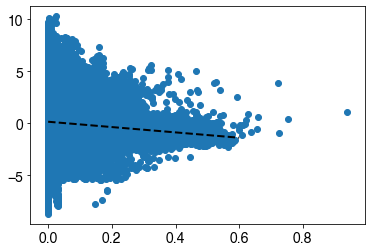

In [71]:
plt.scatter(maize_ha_regrid_1d, gdd_trends_zonal_anom_1d)
plt.plot([0, .6], [mdl_gdd.params[0], mdl_gdd.params[0]+.6*mdl_gdd.params[1]], '--k', lw=2)

KeyboardInterrupt: 

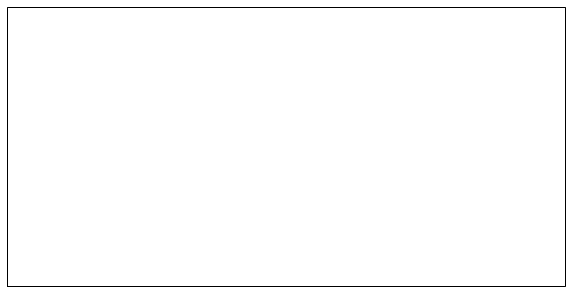

In [72]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-128, -67, 23, 46])

v1 = -10
v2 = 10.01
vstep = .5
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_lon, era5_lat, slopes[:,:,4], cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
# ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
ax.coastlines()
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

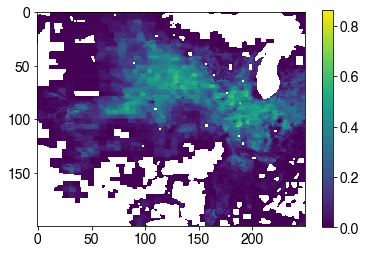

In [30]:
plt.imshow(maize_ha[500:700,:][:,900:1150]);plt.colorbar()

In [8]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dirAgData)
sacksMaizeStart = sacksMaizeNc['plant'].values + 1
sacksMaizeStart = np.roll(sacksMaizeStart, -int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeStart[sacksMaizeStart < 0] = np.nan
sacksMaizeEnd = sacksMaizeNc['harvest'].values + 1
sacksMaizeEnd = np.roll(sacksMaizeEnd, -int(sacksMaizeEnd.shape[1]/2), axis=1)
sacksMaizeEnd[sacksMaizeEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

sacksSoybeanNc = xr.open_dataset('%s/sacks/Soybeans.crop.calendar.fill.nc'%dirAgData)
sacksSoybeanStart = sacksSoybeanNc['plant'].values + 1
sacksSoybeanStart = np.roll(sacksSoybeanStart, -int(sacksSoybeanStart.shape[1]/2), axis=1)
sacksSoybeanStart[sacksSoybeanStart < 0] = np.nan
sacksSoybeanEnd = sacksSoybeanNc['harvest'].values + 1
sacksSoybeanEnd = np.roll(sacksSoybeanEnd, -int(sacksSoybeanEnd.shape[1]/2), axis=1)
sacksSoybeanEnd[sacksSoybeanEnd < 0] = np.nan


In [ ]:
era5_tx = xr.open_mfdataset('%s/daily/tasmax_*.nc'%dirEra5)